In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

Exercise 1


In [12]:
in_dir = 'data/'
in_file = 'ex6_ImagData2Load.mat'
data = sio.loadmat(in_dir + in_file)
ImgT1 = data['ImgT1']
ImgT2 = data['ImgT2']
ROI_GM = data['ROI_GM'].astype(bool)
ROI_WM = data['ROI_WM'].astype(bool)

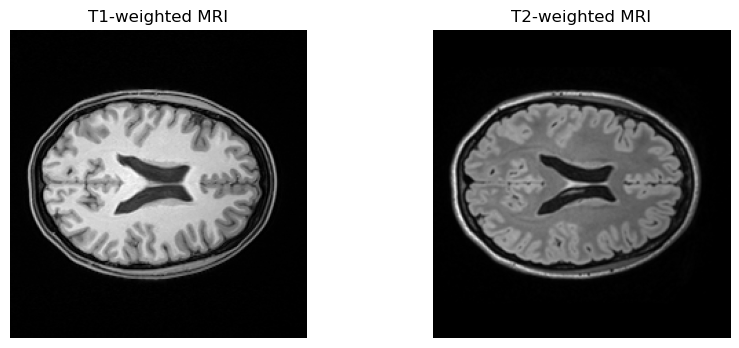

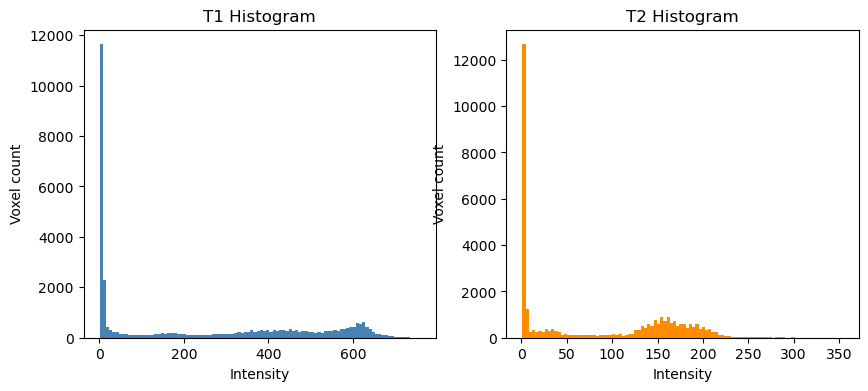

In [13]:
mask = (ImgT1 > 0) & (ImgT2 > 0)
vals_T1 = ImgT1[mask].ravel()
vals_T2 = ImgT2[mask].ravel()


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(ImgT1, cmap='gray')
ax[0].set_title('T1-weighted MRI')
ax[0].axis('off')

ax[1].imshow(ImgT2, cmap='gray')
ax[1].set_title('T2-weighted MRI')
ax[1].axis('off')

plt.show()


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(vals_T1, bins=100, color='steelblue')
ax[0].set_title('T1 Histogram')
ax[0].set_xlabel('Intensity')
ax[0].set_ylabel('Voxel count')

ax[1].hist(vals_T2, bins=100, color='darkorange')
ax[1].set_title('T2 Histogram')
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('Voxel count')

plt.show()

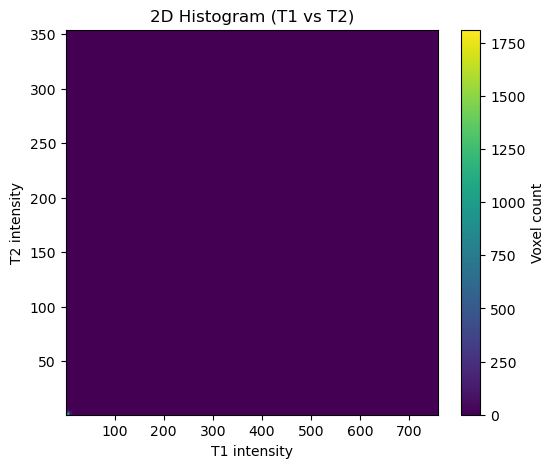

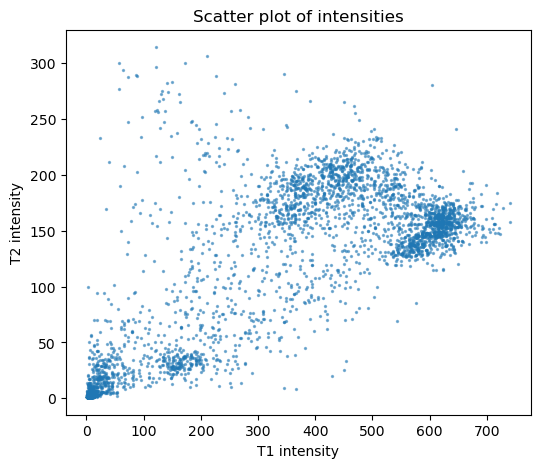

In [15]:
plt.figure(figsize=(6, 5))
plt.hist2d(vals_T1, vals_T2, bins=500)
plt.colorbar(label='Voxel count')
plt.xlabel('T1 intensity')
plt.ylabel('T2 intensity')
plt.title('2D Histogram (T1 vs T2)')
plt.show()


N = 5000  #number of points
idx = np.random.choice(len(vals_T1), N, replace=False)

plt.figure(figsize=(6, 5))
plt.scatter(vals_T1[idx], vals_T2[idx], s=2, alpha=0.5)
plt.xlabel('T1 intensity')
plt.ylabel('T2 intensity')
plt.title('Scatter plot of intensities')
plt.show()


### Q1
T1 - A threshold of 500 can separate them i think
T2 - A threshold of roughly 175 can separate them

I dont know why my 2D histogram does not work...

### Q2
Not really - Maybe you can see that there are clusters in the clouds, but it is hard to draw a clear line and see a good correlation between the two

Exercise 2

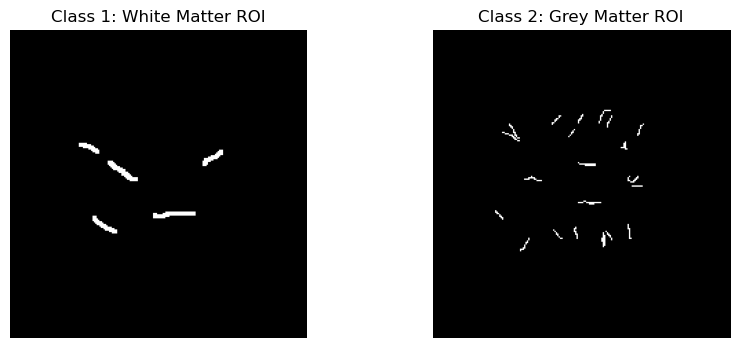

In [16]:
C1 = ROI_WM
C2 = ROI_GM

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].imshow(C1, cmap='gray')
ax[0].set_title('Class 1: White Matter ROI')
ax[0].axis('off')

ax[1].imshow(C2, cmap='gray')
ax[1].set_title('Class 2: Grey Matter ROI')
ax[1].axis('off')

plt.show()


It does not look like i expected it to. I expected to see that almost all white matter was marked and all grey matter was too in C2. Of course it is not necessary to mark everything to train the model

Exercise 3

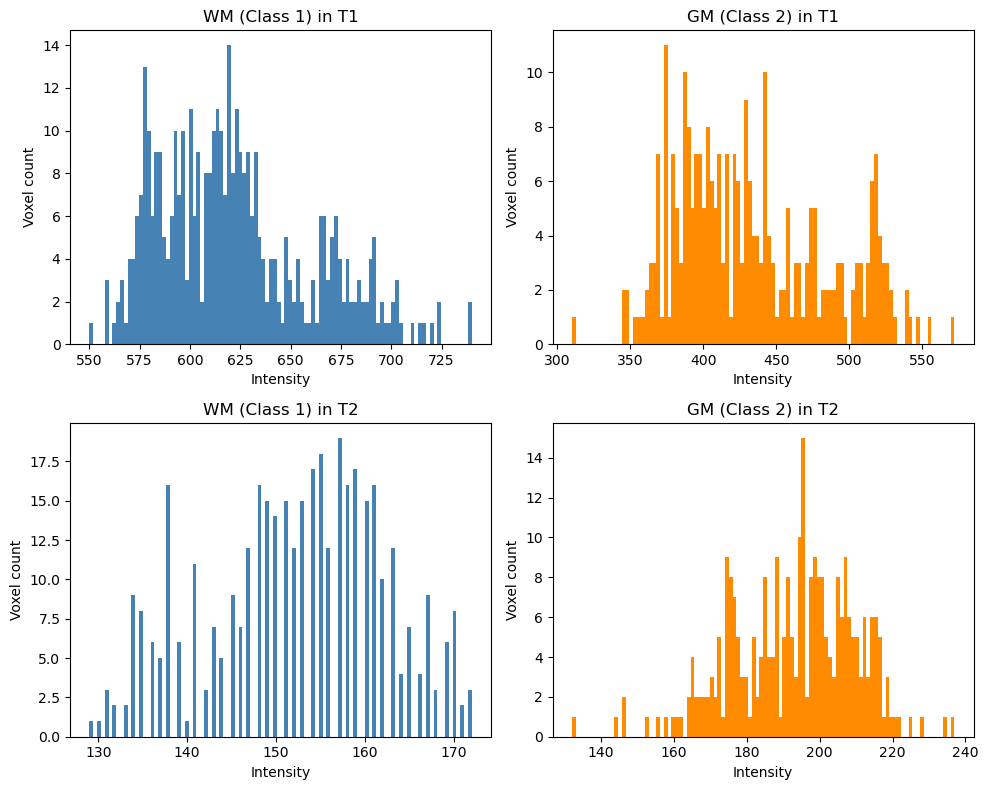

In [17]:
vals_C1_T1 = ImgT1[ROI_WM]
vals_C1_T2 = ImgT2[ROI_WM]

vals_C2_T1 = ImgT1[ROI_GM]
vals_C2_T2 = ImgT2[ROI_GM]

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0,0].hist(vals_C1_T1.ravel(), bins=100, color='steelblue')
ax[0,0].set_title('WM (Class 1) in T1')
ax[0,0].set_xlabel('Intensity')
ax[0,0].set_ylabel('Voxel count')

ax[0,1].hist(vals_C2_T1.ravel(), bins=100, color='darkorange')
ax[0,1].set_title('GM (Class 2) in T1')
ax[0,1].set_xlabel('Intensity')
ax[0,1].set_ylabel('Voxel count')

ax[1,0].hist(vals_C1_T2.ravel(), bins=100, color='steelblue')
ax[1,0].set_title('WM (Class 1) in T2')
ax[1,0].set_xlabel('Intensity')
ax[1,0].set_ylabel('Voxel count')

ax[1,1].hist(vals_C2_T2.ravel(), bins=100, color='darkorange')
ax[1,1].set_title('GM (Class 2) in T2')
ax[1,1].set_xlabel('Intensity')
ax[1,1].set_ylabel('Voxel count')

plt.tight_layout()
plt.show()

Here in the training data it can be seen that all intensities fall within shorter ranges, which is good. And the WM and GM is pretty easy to separate compared to looking at a 1D histogram of the entire image

Exercise 4

In [18]:
X_C1 = np.column_stack((vals_C1_T1, vals_C1_T2))
X_C2 = np.column_stack((vals_C2_T1, vals_C2_T2))

X = np.vstack((X_C1, X_C2))

T_C1 = np.zeros(len(X_C1), dtype=int)
T_C2 = np.ones(len(X_C2), dtype=int)

T = np.concatenate((T_C1, T_C2))

Exercise 5

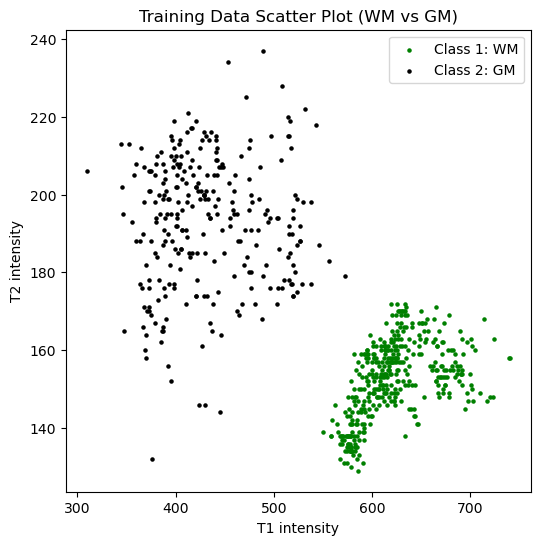

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(vals_C1_T1, vals_C1_T2, c='green', s=5, label='Class 1: WM')
plt.scatter(vals_C2_T1, vals_C2_T2, c='black', s=5, label='Class 2: GM')

plt.xlabel('T1 intensity')
plt.ylabel('T2 intensity')
plt.title('Training Data Scatter Plot (WM vs GM)')
plt.legend()
plt.show()

The seperation appears way better here, there is a clear and defined line that we can draw in this scatter plot

Exercise 6

In [25]:
from data.LDA import LDA

W = LDA(X, T)
print("Weight coefficients (W):")
print(W)


Weight coefficients (W):
[[-138.11536977    0.27566672    0.68044071]
 [-131.32787698    0.15900268    0.99568003]]


Exercise 7

In [26]:
Xall = np.c_[ImgT1.ravel(), ImgT2.ravel()]
Y = np.c_[np.ones((len(Xall), 1)), Xall] @ W.T

Exercise 8

In [27]:
PosteriorProb = np.clip(np.exp(Y) / np.sum(np.exp(Y),1)[:, np.newaxis], 0, 1)

Exercise 9

In [29]:
idx_class1 = np.where(PosteriorProb[:, 0] > 0.5)[0]
idx_class2 = np.where(PosteriorProb[:, 1] > 0.5)[0]

Segmentation = np.zeros(len(PosteriorProb), dtype=int)
Segmentation[idx_class1] = 1  #WM
Segmentation[idx_class2] = 2  #GM

#reshape to image
Segmentation_img = Segmentation.reshape(ImgT1.shape)


Exercise 10

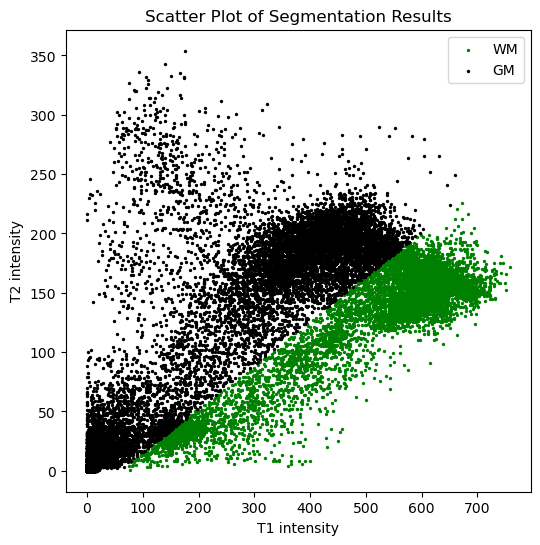

In [30]:
T1_flat = ImgT1.ravel()
T2_flat = ImgT2.ravel()

Seg_flat = Segmentation_img.ravel()

#scatter plot WM = green, GM = black
plt.figure(figsize=(6,6))
plt.scatter(T1_flat[Seg_flat == 1], T2_flat[Seg_flat == 1], c='green', s=2, label='WM')
plt.scatter(T1_flat[Seg_flat == 2], T2_flat[Seg_flat == 2], c='black', s=2, label='GM')

plt.xlabel('T1 intensity')
plt.ylabel('T2 intensity')
plt.title('Scatter Plot of Segmentation Results')
plt.legend()
plt.show()